#  Análisis de movilidad urbana con datos de taxis en la Ciudad de Nueva York
La Comisión de Taxis y Limusinas de Nueva York (TLC), creada en 1971, es la entidad encargada de regular y otorgar licencias a los taxis amarillos, taxis verdes, vehículos de alquiler, vans de transporte y servicios de paratránsito en la ciudad. La agencia recopila los registros de cada viaje realizado por los conductores y vehículos autorizados. Estos datos, disponibles públicamente a través de la página de registros de viajes de la TLC, sirven como base para el análisis utilizado en este proyecto.

Dataset: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

### Objetivos
1. Data Collection: Importar datos formato parquet a un entorno de big data.
2. Data Processing, Cleaning & Transformation: Usar Spark o librerías de Python como Pandas para preparar los datos.
3. Exploratory Data Analysis (EDA): Realizar análisis básicos y visualizar patrones en los datos.
4. Data Visualization: Utilizar herramientas como Matplotlib para mostrar los resultados desde web.



### Librerias necesarias

In [1]:
#pip install pandas
#pip install pyspark
#pip install matplotlib
#pip install streamlit

### 1. Importar librerias

In [2]:
import os
import glob

from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as spark_sum, when, col, count, max, min, desc, mean, hour, dayofweek, month
from functools import reduce

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spark = SparkSession.builder.appName("NYCTaxiAnalysis").getOrCreate()
print('Spark version:', spark.version)

Spark version: 4.0.1


### 2. Importar datos

In [4]:
dataset_folder = "../raw_data"
files = os.listdir(dataset_folder)
print(len(files), "archivos encontrados")

paths = [
    os.path.join(dataset_folder, f)
    for f in files
    if f.startswith("yellow_tripdata_") and f.endswith(".parquet")
]

# Opcional utilizando reduce
#dfs = [spark.read.parquet(p) for p in paths]
#taxi_rides_df = reduce(lambda a, b: a.unionByName(b), dfs)

taxi_rides_df = spark.read.parquet(*paths)
taxi_rides_df.show(5) #taxi_rides_df.take(5)

12 archivos encontrados
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|           2|       17.7

In [5]:
taxi_rides_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



### 3. Limpieza y transformación de datos

In [6]:
# Convierte "Y" y "N" en 1 y 2 para facilitar cálculos, filtrados y modelos que requieren valores numéricos
taxi_rides_df = taxi_rides_df.withColumn(
    "store_and_fwd_flag",
    when(col("store_and_fwd_flag") == "Y", 1)
    .when(col("store_and_fwd_flag") == "N", 2)
    .otherwise(2)
)

taxi_rides_df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 2|         186|          79|           2|       17.7|  1.0|    0.5|       0.

In [7]:
# Número de valores nulos por columna
taxi_rides_df.select([count(when(col(c).isNull(), c)).alias(c) for c in taxi_rides_df.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|        4091232|            0|   4091232|                 0|           0|           0|           0|          0|    0|      0|         

In [8]:
# Completar valores faltantes con la moda de 'store_and_fwd_flag'
store_mode = (
    taxi_rides_df
        .groupBy("store_and_fwd_flag")
        .count()
        .orderBy(desc("count"))
        .first()["store_and_fwd_flag"]
)

# Completar valores faltantes de 'passenger_count' con la mediana
median_passenger = (
    taxi_rides_df.approxQuantile("passenger_count", [0.5], 0.01)[0]
)

# Completar valores faltantes de 'RatecodeID' con la moda
ratecode_mode = (
    taxi_rides_df
        .groupBy("RatecodeID")
        .count()
        .orderBy(desc("count"))
        .first()["RatecodeID"]
)

# Completar valores faltantes de 'congestion_surcharge' y 'Airport_fee' con la media
mean_congestion = taxi_rides_df.select(mean("congestion_surcharge")).first()[0]
mean_airport_fee = taxi_rides_df.select(mean("Airport_fee")).first()[0]

# Aplicar los reemplazos
taxi_rides_df = (
    taxi_rides_df
        .fillna({"store_and_fwd_flag": store_mode})
        .fillna({"passenger_count": median_passenger})
        .fillna({"RatecodeID": ratecode_mode})
        .fillna({"congestion_surcharge": mean_congestion})
        .fillna({"Airport_fee": mean_airport_fee})
)

In [9]:
# Comprobar valores nulos por columna
taxi_rides_df.select([count(when(col(c).isNull(), c)).alias(c) for c in taxi_rides_df.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         

In [10]:
# Obtener los 10 viajes con mayor distancia ordenados
sorted_df = taxi_rides_df.sort("trip_distance", ascending=False)
sorted_df.show(10)
# Detalles del plan físico optimizado
sorted_df.explain(extended=True)  # Plan extendido con particiones y estadísticas

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|        Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-------------------+
|       2| 2024-11-28 19:28:00|  2024-11-28 19:42:00|              1|    398608.62|         1|                 2|         151|         140|           0|      22.04

In [11]:
# Transformar el dataframe en una tabla o vista temporal
taxi_rides_df.createOrReplaceTempView("taxi_rides")

In [12]:
# Ahora podemos consultar con una consulta SQL los días con mayor número de viajes
sqlWay = spark.sql("""
SELECT
  DATE(tpep_pickup_datetime) AS pickup_date,
  COUNT(*) AS trip_count,
  AVG(trip_distance) AS avg_trip_distance,
  AVG(total_amount) AS avg_total_amount,
  AVG(passenger_count) AS avg_passenger_count
FROM taxi_rides
GROUP BY DATE(tpep_pickup_datetime)
ORDER BY trip_count DESC;
""")

sqlWay.show(10)
sqlWay.explain()

+-----------+----------+------------------+------------------+-------------------+
|pickup_date|trip_count| avg_trip_distance|  avg_total_amount|avg_passenger_count|
+-----------+----------+------------------+------------------+-------------------+
| 2024-12-13|    159845| 4.067622759548322| 28.44302893427827| 1.2952234977634582|
| 2024-12-14|    159150| 4.274076217404958|26.447940119382736| 1.3810556079170593|
| 2024-12-12|    156911| 4.428184002396263|30.760707025000222| 1.2430039958957626|
| 2024-11-21|    153149| 4.552283854285691|28.761140849758704|  1.207895578815402|
| 2024-11-22|    150016| 4.444827485068239| 27.43154370200305| 1.2630452751706485|
| 2024-11-16|    149939| 5.583773934733454|25.453496288489518|  1.335056256210859|
| 2024-10-26|    148481| 4.774529333719506| 26.75943130770748|  1.365979485590749|
| 2024-12-05|    148377| 4.605283096436819| 29.70562128901142| 1.2521954211232198|
| 2024-12-06|    147460| 6.090470771734707| 29.05897551878297| 1.3100569646005698|
| 20

In [13]:
# Consultar con SQL el promedio de distancia, propina y tipo de pago
sqlWay = spark.sql("""
SELECT
    payment_type,
    ROUND(AVG(trip_distance), 2) AS avg_distance,
    ROUND(AVG(total_amount), 2) AS avg_total_amount,
    ROUND(AVG(tip_amount), 2) AS avg_tip_amount
FROM taxi_rides
GROUP BY payment_type
ORDER BY payment_type;
""")

sqlWay.show(10)

+------------+------------+----------------+--------------+
|payment_type|avg_distance|avg_total_amount|avg_tip_amount|
+------------+------------+----------------+--------------+
|           0|       18.33|           24.61|          0.76|
|           1|        3.54|           29.91|          4.37|
|           2|        3.35|           23.46|           0.0|
|           3|        2.62|            9.26|          0.02|
|           4|        3.57|            2.04|          0.05|
|           5|         0.0|            15.5|           0.0|
+------------+------------+----------------+--------------+



In [43]:
# Filtrar valores
taxi_rides_df = taxi_rides_df.filter((col("trip_distance") > 0) & (col("trip_distance") <= 100))
taxi_rides_df = taxi_rides_df.filter(col("total_amount") > 0)

# Filtro para 'fare_amount' si la columna existe
if "fare_amount" in taxi_rides_df.columns:
    taxi_rides_df = taxi_rides_df.filter(
        (col("fare_amount") > 0) &
        (col("fare_amount") < 1000)
    )

# Filtro para 'passenger_count' si la columna existe
if "passenger_count" in taxi_rides_df.columns:
    taxi_rides_df = taxi_rides_df.filter(
        (col("passenger_count") > 0) &
        (col("passenger_count") <= 6)
    )

# Filtrar datos para evitar valores extremos
if "trip_distance" in taxi_rides_df.columns:
    taxi_rides_df = taxi_rides_df.filter(
        (col("trip_distance") > 0) &
        (col("trip_distance") <= 30) &
        (col("total_amount") > 0) &
        (col("total_amount") > 150)
    )

if "tpep_pickup_datetime" in taxi_rides_df.columns:
    taxi_rides_df = taxi_rides_df.withColumn('hour', hour(col('tpep_pickup_datetime')))
    taxi_rides_df = taxi_rides_df.withColumn('day_of_week', dayofweek(col('tpep_pickup_datetime')))
    taxi_rides_df = taxi_rides_df.withColumn('month', month(col('tpep_pickup_datetime')))
    taxi_rides_df = taxi_rides_df.withColumn('is_weekend', when(col('day_of_week').isin([1,7]),1).otherwise(0))


# Validar Rango Location
valid_min = 1
valid_max = 265
taxi_rides_df = taxi_rides_df.filter(
    (col("PULocationID").between(valid_min, valid_max)) &
    (col("DOLocationID").between(valid_min, valid_max))
)

taxi_rides_df = taxi_rides_df.withColumn(
    "payment_type_name",
    when(col("payment_type") == 1, "Credit Card")
    .when(col("payment_type") == 2, "Cash")
    .when(col("payment_type") == 3, "No charge")
    .when(col("payment_type") == 4, "Dispute")
    .otherwise("Other")
)

taxi_rides_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----------+-----+----------+-----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|hour|day_of_week|month|is_weekend|payment_type_name|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----------+-----+----------+-----------------+
|       2| 2024-01-01 00:42:24|

In [44]:
# Máximos y mínimos de distancia e importe total
taxi_rides_df.select(
    max(col("trip_distance")).alias("max_trip_distance"),
    min(col("trip_distance")).alias("min_trip_distance"),
    max(col("total_amount")).alias("max_total_amount"),
    min(col("total_amount")).alias("min_total_amount")
).show()

+-----------------+-----------------+----------------+----------------+
|max_trip_distance|min_trip_distance|max_total_amount|min_total_amount|
+-----------------+-----------------+----------------+----------------+
|             30.0|             0.01|         1737.18|          150.01|
+-----------------+-----------------+----------------+----------------+



In [45]:
rutas_frecuentes = (
    taxi_rides_df
        .groupBy("PULocationID", "DOLocationID")
        .count()
        .withColumnRenamed("count", "total_viajes")
        .sort(desc("total_viajes"))
        .limit(5)
)

# Mostrar el resultado del Top 5
rutas_frecuentes.show()
# Explicación del DAG: Mostrar el plan de ejecución para la consulta con DataFrame API
rutas_frecuentes.explain()

+------------+------------+------------+
|PULocationID|DOLocationID|total_viajes|
+------------+------------+------------+
|         132|         265|       10551|
|         138|         265|        4267|
|         230|           1|        1823|
|         161|           1|        1720|
|         163|           1|        1579|
+------------+------------+------------+

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- TakeOrderedAndProject(limit=5, orderBy=[total_viajes#980L DESC NULLS LAST], output=[PULocationID#7,DOLocationID#8,total_viajes#980L])
   +- HashAggregate(keys=[PULocationID#7, DOLocationID#8], functions=[count(1)])
      +- Exchange hashpartitioning(PULocationID#7, DOLocationID#8, 200), ENSURE_REQUIREMENTS, [plan_id=944]
         +- HashAggregate(keys=[PULocationID#7, DOLocationID#8], functions=[partial_count(1)])
            +- Project [PULocationID#7, DOLocationID#8]
               +- Filter (((((((((((((((((isnotnull(trip_distance#4) AND isnotnull(total_amount#1

### 4. Muestra utilizando Pandas

In [46]:
# Nuevo DF con Pandas tomando una muestra
sample_df = taxi_rides_df.select("DOLocationID", "PULocationID", "trip_distance", "fare_amount", "tip_amount", "total_amount", "payment_type", "mta_tax", "passenger_count", "is_weekend", "hour", "day_of_week", "month") \
    .sample(withReplacement=False, fraction=0.25) \
    .toPandas()

### 5. Analisís utilizando gráficos

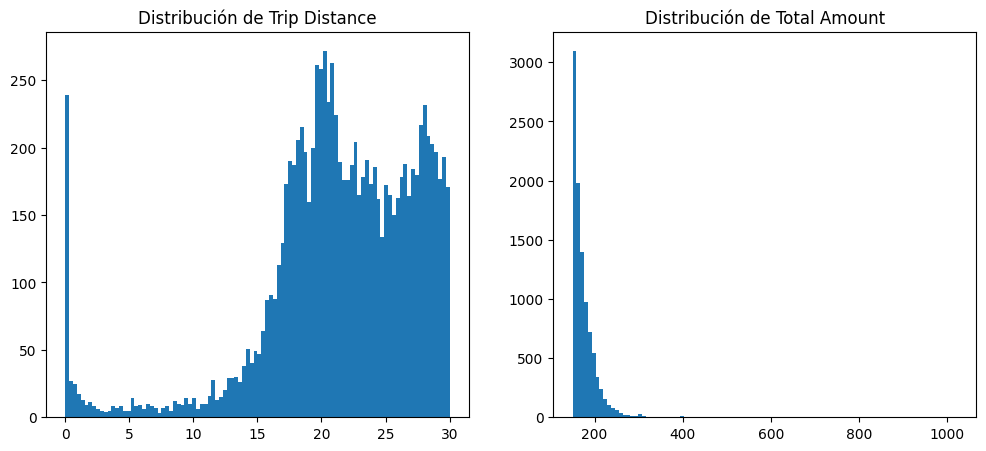

In [47]:
# Mostrar histogramas de distancia y total amount
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(sample_df["trip_distance"], bins=100)
plt.title("Distribución de Trip Distance")

plt.subplot(1, 2, 2)
plt.hist(sample_df["total_amount"], bins=100)
plt.title("Distribución de Total Amount")

plt.show()

In [48]:
# Promedio trip_distance
avg_trip_distance = sample_df['trip_distance'].mean()
print(f"Average Trip Distance: {avg_trip_distance}")

# Promedio fare_amount
avg_fare_amount = sample_df['fare_amount'].mean()
print(f"Average Fare Amount: {avg_fare_amount}")

# Promedio tip_amount
avg_tip_amount = sample_df['tip_amount'].mean()
print(f"Average Tip Amount: {avg_tip_amount}")

passenger_count_dist = sample_df['passenger_count'].value_counts()
print(passenger_count_dist)

Average Trip Distance: 21.37176964303772
Average Fare Amount: 134.6600414602083
Average Tip Amount: 24.643676812620082
passenger_count
1    6806
2    1760
3     634
4     598
5      66
6      25
Name: count, dtype: int64


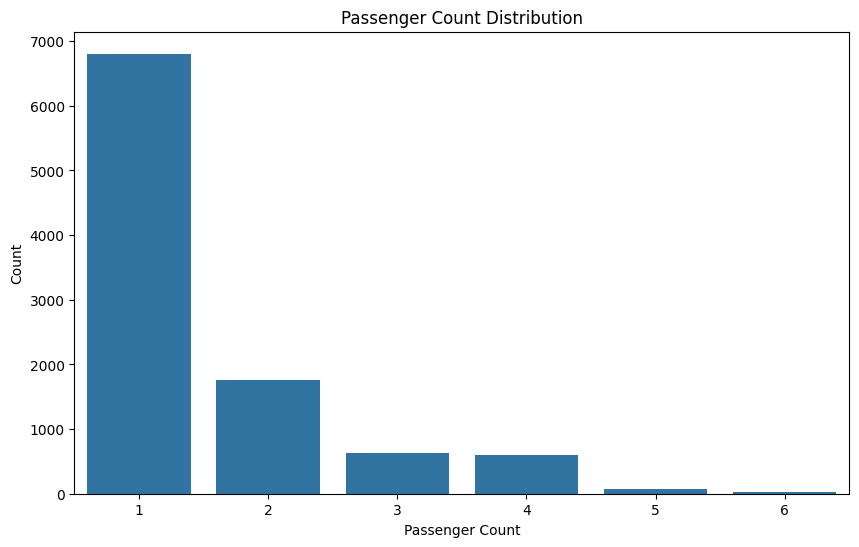

In [49]:
# Distribución de Pasajeros
plt.figure(figsize=(10, 6))
sns.countplot(x='passenger_count', data=sample_df)
plt.title('Passenger Count Distribution')
plt.xlabel('Passenger Count')
plt.ylabel('Count')
plt.show()

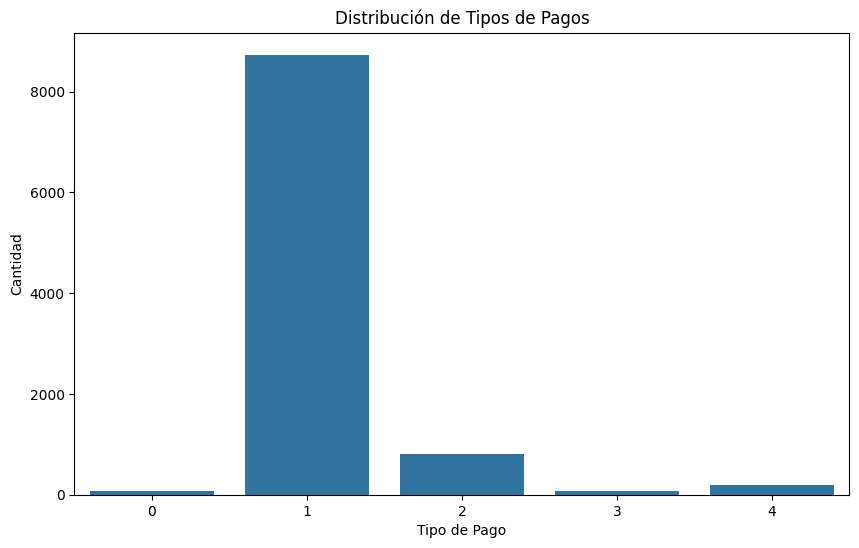

In [50]:
# Distribución de Tipos de Pagos
plt.figure(figsize=(10, 6))
sns.countplot(x='payment_type', data=sample_df)
plt.title('Distribución de Tipos de Pagos')
plt.xlabel('Tipo de Pago')
plt.ylabel('Cantidad')
plt.show()

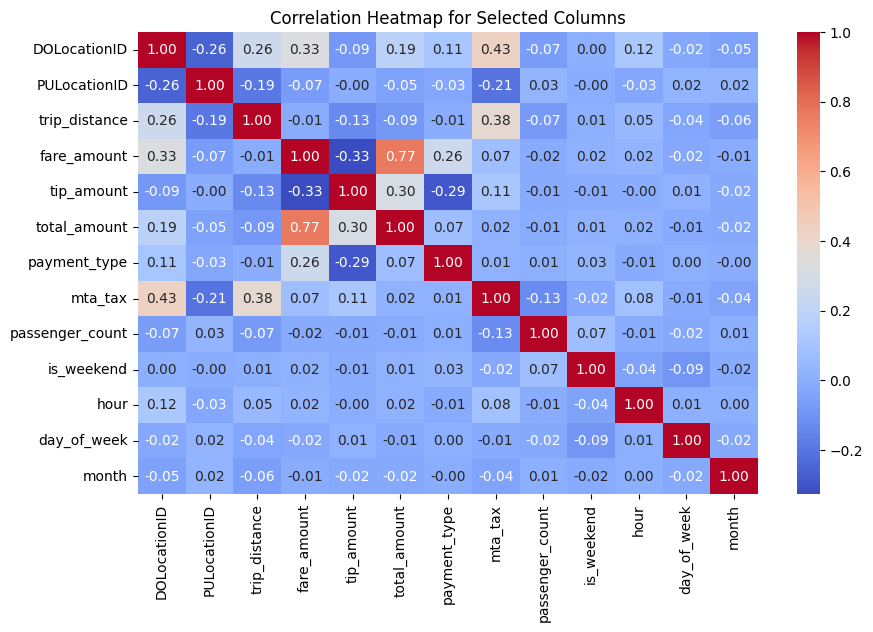

In [51]:
corr_matrix = sample_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f')
plt.title('Correlation Heatmap for Selected Columns')
plt.show()

### 6. Exportar datos

In [52]:
sample_df.to_parquet("../data/taxi_data_outl")
#taxi_rides_df.write.parquet("../data/taxi_data_ok")

In [53]:
#jupyter nbconvert --to html data_processing.ipynb